## Bigrams Generation

We will reuse the `tokens.tsv` file generated in the `02-wordcounts` notebook to construct bigrams and then use that to compute frequent bigrams. Before starting, run the following commands.

    cp ../data/tokens.tsv ../data/unigrams_left.tsv
    cp ../data/tokens.tsv ../data/unigrams_right.tsv

Remove last line from unigrams_left.tsv and first line from unigrams_right.tsv

    paste -d "\t" ../data/unigrams_left.tsv ../data/unigrams_right.tsv > ../data/bigrams.tsv
    rm unigrams_left.tsv unigrams_right.tsv
    
We will now operate on the bigrams.tsv file.

In [1]:
import matplotlib.pyplot as plt
import nltk
import os
import re
import sqlite3
import string

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
DATA_DIR = "../data"

In [3]:
# format: (word_id_1 | word_1 | doc_id_1 | word_id_2 | word_2 | doc_id_2)
BIGRAMS_FILE = os.path.join(DATA_DIR, "bigrams.tsv")

# target DB
WORDCOUNTS_DB = os.path.join(DATA_DIR, "wordcounts.db")

# candidate bigrams
CANDIDATE_BIGRAMS = os.path.join(DATA_DIR, "candidate_bigrams.tsv")

In [4]:
def table_exists(conn, table_name):
    cur = conn.cursor()
    cur.execute("select name from sqlite_master where type='table' and name = ?", 
                [table_name])
    rows = cur.fetchall()
    cur.close()
    return len(rows) > 0
    

def create_bigrams_table(conn):
    if not table_exists(conn, "bigrams"):
        cur = conn.cursor()
        create_table = """create table bigrams(
            bigram_id INTEGER NOT NULL,
            wid_1 INTEGER NOT NULL,
            word_1 VARCHAR(50) NOT NULL,
            wid_2 INTEGER NOT NULL,
            word_2 VARCHAR(50) NOT NULL,
            doc_id INTEGER NOT NULL)
        """
        cur.execute(create_table)
        cur.close()

        
def index_exists(conn, index_name):
    cur = conn.cursor()
    cur.execute("select name from sqlite_master where type='index' and name = ?", 
                [index_name])
    rows = cur.fetchall()
    cur.close()
    return len(rows) > 0


def create_bigrams_indexes(conn):
    cur = conn.cursor()
    index_names = ["ix_bigrams", "ax1_bigrams", "ax2_bigrams"]
    create_indexes = [
        "create unique index ix_bigrams on bigrams(bigram_id)",
        "create index ax1_bigrams on bigrams(word_1, word_2)",
        "create index ax2_bigrams on bigrams(doc_id)"
    ]
    for index_name, create_index in zip(index_names, create_indexes):
        if not index_exists(conn, index_name):
            cur.execute(create_index)
    cur.close()

        
def count_bigram_rows(conn):
    cur = conn.cursor()
    cur.execute("select count(*) as cnt from bigrams")
    rows = cur.fetchone()
    return int(rows[0])
    cur.close()

    
def insert_bigram(conn, bid, wid_1, word_1, wid_2, word_2, doc_id, commit=False):
    cur = conn.cursor()
    cur.execute("""insert into bigrams(bigram_id, wid_1, word_1, wid_2, word_2, doc_id) 
        values (?, ?, ?, ?, ?, ?)""", [bid, wid_1, word_1, wid_2, word_2, doc_id])
    if commit:
        conn.commit()
    cur.close()

    
conn = sqlite3.connect(WORDCOUNTS_DB)
create_bigrams_table(conn)

In [5]:
num_bigrams = count_bigram_rows(conn)
if num_bigrams == 0:
    # load table
    bigram_id = 0
    should_commit = False
    fbgs = open(BIGRAMS_FILE, "r")
    for line in fbgs:
        cols = line.strip().split("\t")
        if len(cols) != 6:
            # skip bigrams with embedded newlines
            continue
        wid_1 = int(cols[0])
        word_1 = cols[1]
        doc_id_1 = int(cols[2])
        wid_2 = int(cols[3])
        word_2 = cols[4]
        doc_id_2 = int(cols[5])
        # skip entries that span documents
        if doc_id_1 != doc_id_2:
            continue
        # skip entries that span sentences
        if word_1 == "." or word_2 == ".":
            continue
        if len(word_1) == 0 or len(word_2) == 0:
            continue
        if bigram_id % 1000 == 0:
            print("{:d} bigrams loaded".format(bigram_id))
            should_commit = True
        insert_bigram(conn, bigram_id, wid_1, word_1, wid_2, word_2, doc_id_1, should_commit)
        should_commit = False
        bigram_id += 1
    fbgs.close()
    conn.commit()

In [6]:
create_bigrams_indexes(conn)

### Most Frequent Bigrams

In [7]:
def bigram_counts(conn, min_freq=-1, top_n=-1):
    cur = conn.cursor()
    count_sql = """
        SELECT word_1, word_2, count(*) as cnt
        FROM bigrams
        GROUP BY word_1, word_2
    """
    if min_freq != -1:
        count_sql += " HAVING cnt > {:d}".format(min_freq)
    count_sql += " ORDER BY cnt DESC"
    if top_n != -1:
        count_sql += " LIMIT {:d}".format(top_n)
    cur.execute(count_sql)
    rows = cur.fetchall()
    return [(row[0], row[1], row[2]) for row in rows]

In [8]:
english_stopwords = set(stopwords.words('english'))


def is_too_short(word):
    if len(word) < 2:
        return True
    elif len(word) == 2 and word.endswith("."):
        return True
    else:
        return False
    
    
def is_number_or_fraction(word):
    return re.match(r"(\d)+(\.(\d)+)*", word) is not None


def is_all_punctuation(word):
    chars = [c for c in word if c not in string.punctuation]
    return len(chars) == 0

In [9]:
candidate_bigrams = []
most_frequent_bigrams = bigram_counts(conn, top_n=20000)
for word_1, word_2, freq in most_frequent_bigrams:
    if word_1 in english_stopwords or word_2 in english_stopwords:
        continue
    if is_too_short(word_1) or is_too_short(word_2):
        continue
    if is_number_or_fraction(word_1) or is_number_or_fraction(word_2):
        continue
    if is_all_punctuation(word_1) or is_all_punctuation(word_2):
        continue
    
#     print(word_1, word_2, freq)
    candidate_bigrams.append((word_1, word_2, freq))
    
print("{:d} candidate bigrams".format(len(candidate_bigrams)))

2280 candidate bigrams


### Candidates for further analysis

We attempt to plot the frequencies to see if there is any kind of cutoff we can put in to make sure we only look at good bigrams. But scrolling through the list shows that we have good candidates even towards the bottom of the list, so we decide to hold on to all generated bigrams. We will write it out to a new file `candidate_bigrams.tsv` which our next few notebooks will look at.

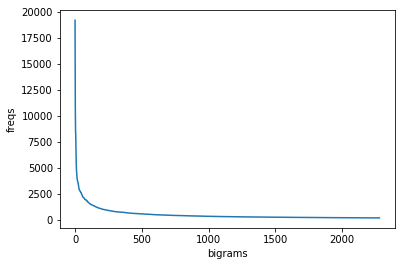

In [10]:
plt.plot([cb[2] for cb in candidate_bigrams])
plt.xlabel("bigrams")
plt.ylabel("freqs")
plt.show()

In [11]:
fcb = open(CANDIDATE_BIGRAMS, "w")
for word_1, word_2, freq in candidate_bigrams:
    fcb.write("{:s}\t{:s}\t{:d}\n".format(word_1, word_2, freq))
fcb.close()